In [1]:
using Random
using Plots
using DelimitedFiles
using Printf
using BenchmarkTools
using Dates

STEPS = Set([(1, 0), (0, 1), (-1, 0), (0, -1)])

function CartesianToLetter(Path::Vector{Tuple{Int,Int}})::String
    conversion = Dict((0,1)=>'U', (0,-1)=>'D', (-1,0)=>'L', (1,0)=>'R')
    return join([conversion[(Path[i+1][1]-Path[i][1], Path[i+1][2]-Path[i][2])] for i in 1:length(Path)-1])
end

function GetNeighbour(site, step)
    return (site[1] + step[1], site[2] + step[2])
end

GetNeighbour (generic function with 1 method)


Configuration:
# of Steps: 200
# of Spikes: 57
Spike locations: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


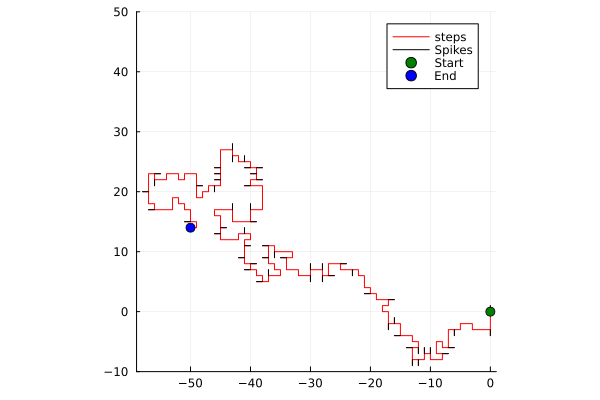

In [2]:
MAX_SIZE = 200

# Retry until a walk of length max_size has been found
n = 0
while n != MAX_SIZE
    global m, spike_loc, Path, s_plots
    site = (0, 0)
    Path = [site]
    last_spike = []
    spike_loc = zeros(Int, MAX_SIZE + 1)
    s_plots = []
    n = m = 0
    a = 1
    
    while n < MAX_SIZE
        if a == 0
            # Terminate the walk early when there is no where else to grow to
            break
        end
        # Get neighbouring sites and enforce self avoidance
        neighbours = [GetNeighbour(site, step) for step in STEPS]
        valid_neighbours = [s for s in neighbours if !(s in Path[1:end-2]) && !(s in last_spike)]
        # Determine the atmosphere, a
        a = length(valid_neighbours)
        if a > 0
            # Step at random to one of the unvisited neighbours
            site = rand(valid_neighbours)
            push!(Path, site)
            n += 1
            # Prevent index being out of bounds
            if n > 1
                # Determine whether a spike has formed
                if site == Path[end-2]
                    # Account for the 2 steps taken to form the spike
                    n -= 2
                    m += 1
                    # Highlight spikes
                    last_spike = Path[end-2:end-1]
                    spike_loc[n + 1] += 1
                    push!(s_plots, last_spike)
                end
            end
        end
    end
end

println("\nConfiguration:")
println("# of Steps: ", n)
println("# of Spikes: ", m)
println("Spike locations: ", spike_loc[1:n+1])

# Plot the walk (includes spikes)
x = [v[1] for v in Path]
y = [v[2] for v in Path]

fig = plot(x, y, linecolor = :red, label= "steps")

# Plot spikes on top
if !isempty(s_plots)
    first_spike = s_plots[1]
    plot!([first_spike[1][1], first_spike[2][1]], [first_spike[1][2], first_spike[2][2]], linecolor = :black, label="Spikes")
    for spike in s_plots[2:end]
        plot!([spike[1][1], spike[2][1]], [spike[1][2], spike[2][2]], linecolor = :black, label=false)
    end
end

# Set legend position
plot!(legend = :best, aspect_ratio = :equal)

# Plot start and end points
scatter!([0], [0], color = :green, markersize=5, label="Start")
scatter!([Path[end][1]], [Path[end][2]], color = :blue, markersize=5, label="End")

# Plot customization
pad = 1
dist_x = maximum(x) - minimum(x)
dist_y = maximum(y) - minimum(y)
longest_axis = max(dist_x, dist_y)

xlims!(minimum(x)-pad, minimum(x)+longest_axis+pad)
ylims!(minimum(y)-pad, minimum(y)+longest_axis+pad)

display(fig)

In [3]:
mutable struct Counter
    counts::Dict{Tuple{Int, Int}, Int}
end

function GenerateCactus!(counts::Counter, steps_left::Int, n::Int=0, m::Int=0, Path::Vector{Tuple{Int, Int}}=[(0, 0)], Spikes::Vector{Tuple{Int, Int}}=Tuple{Int, Int}[])
    """
    Generate cactus walks with n steps in path, forming some spikes
    Each spike is a leaf of the graph given by the two associated points, only saving the tip of the spike.
    """
    if haskey(counts.counts, (n, m))
        counts.counts[(n, m)] += 1
    else
        counts.counts[(n, m)] = 1
    end
    
    if steps_left == 0
        return
    else
        # Compute all the neighbours of the current site
        neighbours = [GetNeighbour(Path[end], step) for step in STEPS]
        # Filter for points not on the Path and points not on Spikes, but allowing for an immediate reversal
        valid_neighbours = [site for site in neighbours if !(site in Path[1:end-2]) && !(site in Spikes)]

        if !isempty(valid_neighbours)
            for new_site in valid_neighbours
                local_n, local_m, local_SL = n, m, steps_left
                if !(new_site in Path)
                    GenerateCactus!(counts, local_SL-1, local_n+1, local_m, vcat(Path, [new_site]), Spikes)
                else
                    GenerateCactus!(counts, local_SL+1, local_n-1, local_m+1, vcat(Path, [new_site]), vcat(Spikes, [Path[end]]))
                end
            end
        end
    end
end

function save_counts(counts::Counter, filename::String, N::Int)
    longest_config = 0
    if isfile(filename)
        open(filename, "r") do f_r
            text = readlines(f_r)
            if !isempty(text)
                longest_config = parse(Int, split(text[end])[1])
            end
        end
    end
    
    if longest_config < N
        open(filename, "a") do f_a
            for (n, m) in sort(collect(keys(counts.counts)))
                if n > longest_config && n < N+1
                    write(f_a, "$(n) $(m) $(4 * counts.counts[(n, m)])\n")
                end
            end
        end
    end
end

# Run exact enumeration
N = 7
counts = Counter(Dict{Tuple{Int, Int}, Int}())
GenerateCactus!(counts, N+1, 1, 0, [(0, 0), (1, 0)], Tuple{Int, Int}[])

# Save data
save_counts(counts, "cactus_saw_counts.ser", N)

# Print results
println("0 0 1")
for (n, m) in sort(collect(keys(counts.counts)))
    if n < N+1
        println(n, " ", m, " ", 4 * counts.counts[(n, m)])
    end
end


0 0 1
0 1 4
1 0 4
1 1 24
1 2 36
2 0 12
2 1 96
2 2 244
2 3 200
3 0 36
3 1 344
3 2 1196
3 3 1776
3 4 952
4 0 100
4 1 1136
4 2 4972
4 3 10472
4 4 10576
4 5 4096
5 0 284
5 1 3672
5 2 19236
5 3 52000
5 4 76216
5 5 57232
5 6 17192
6 0 780
6 1 11456
6 2 70028
6 3 230648
6 4 441072
6 5 488496
6 6 289464
6 7 70768
7 0 2172
7 1 35336
7 2 245684
7 3 951088
7 4 2236936
7 5 3265792
7 6 2884144
7 7 1406448
7 8 289928


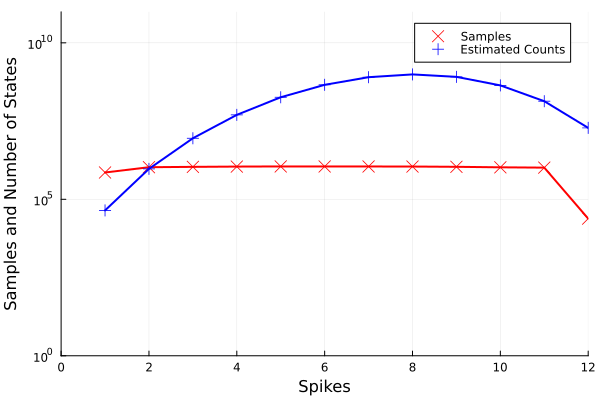

Run 1: 118548.0 ms
Run 2: 118694.0 ms
Run 3: 118824.0 ms
Run 4: 118698.0 ms
Run 5: 118904.0 ms
Run 6: 120788.0 ms
Run 7: 119065.0 ms
Run 8: 118129.0 ms
Run 9: 118289.0 ms
Run 10: 119844.0 ms

Average time over 10 runs: 118978.3 ms
Standard deviation: 788.97 ms


In [4]:
function flatperm_cactus_saw(max_size::Int, max_tours::Int)
    max_steps = 3 * max_size + 2

    # Initialize arrays
    s = zeros(Int, max_size + 2, max_size + 2)
    w = zeros(Float64, max_size + 2, max_size + 2)
    copy = zeros(Int, max_steps + 1)
    weight = zeros(Float64, max_steps + 1)
    spike_loc = zeros(Int, max_size + 2)

    # Preallocate storage
    occupied_sites = Array{Tuple{Int, Int}}(undef, max_steps + 1)
    occ_idx = 1
    occupied_sites[occ_idx] = (0, 0)

    spikes = Array{Tuple{Int, Int}}(undef, max_steps + 1)
    spike_idx = 0

    next_points = Vector{Tuple{Int, Int}}(undef, 4)
    unoccupied_sites = Tuple{Int, Int}[]

    tours = spine = m = N = 0
    a = copy[1] = weight[1] = 1
    s[1, 1] += 1
    w[1, 1] += weight[1]
    site = (0, 0)

    while tours < max_tours
        if spine == max_size || a == 0
            copy[N + 1] = 0
        else
            ratio = weight[N + 1] / (w[spine + 1, m + 1] / s[1, 1])
            p, k = modf(ratio)
            r = rand()
            if r < p
                copy[N + 1] = floor(Int, ratio) + 1
            else
                copy[N + 1] = floor(Int, ratio)
            end
            weight[N + 1] = w[spine + 1, m + 1] / s[1, 1]
        end

        if copy[N + 1] == 0
            while N > 0 && copy[N + 1] == 0
                if spike_loc[spine + 1] > 0
                    m -= 1
                    spike_loc[spine + 1] -= 1
                    spine += 2
                    spike_idx -= 2
                end
                occ_idx -= 1
                site = occupied_sites[occ_idx]
                spine -= 1
                N -= 1
            end
        end

        if N == 0 && copy[1] == 0
            tours += 1
            a = 1
            copy[1] = 1
            s[1, 1] += 1
            w[1, 1] += weight[1]
            occ_idx = 1
            occupied_sites[occ_idx] = (0, 0)
            spike_idx = 0
        else
            for (i, step) in enumerate(STEPS)
                next_points[i] = GetNeighbour(occupied_sites[occ_idx], step)
            end

            empty!(unoccupied_sites)
            for i in 1:4
                pt = next_points[i]
                is_on_path = false
                for j in 1:(occ_idx - 2)
                    if pt == occupied_sites[j]
                        is_on_path = true
                        break
                    end
                end
                if !is_on_path
                    for j in 1:spike_idx
                        if pt == spikes[j]
                            is_on_path = true
                            break
                        end
                    end
                end
                if !is_on_path
                    push!(unoccupied_sites, pt)
                end
            end

            a = length(unoccupied_sites)
            if a > 0
                copy[N + 1] -= 1
                site = rand(unoccupied_sites)
                occ_idx += 1
                occupied_sites[occ_idx] = site
                spine += 1
                N += 1

                if spine > 1 && site == occupied_sites[occ_idx - 2]
                    spike_idx += 1
                    spikes[spike_idx] = occupied_sites[occ_idx - 2]
                    spike_idx += 1
                    spikes[spike_idx] = occupied_sites[occ_idx - 1]
                    m += 1
                    spine -= 2
                    spike_loc[spine + 1] += 1
                end

                weight[N + 1] = weight[N] * a
                s[spine + 1, m + 1] += 1
                w[spine + 1, m + 1] += weight[N + 1]
            end
        end
    end

    s[1, 1] -= 1
    w[1, 1] -= 1

    norm = s[1, 1] != 0 ? s[1, 1] : 1e-10
    return s, w ./ norm
end


# Example
max_size = 10
max_tours = 1000000

s, w = flatperm_cactus_saw(max_size + 2, max_tours)




# Extract samples and weights for max spine length
max_size_samples = s[max_size + 1, :]
max_size_samples = max_size_samples[max_size_samples .!= 0]

estimated_counts = w[max_size + 1, :]
estimated_counts = estimated_counts[estimated_counts .!= 0]

# Plot the results
plot(max_size_samples, seriestype=:scatter, label="Samples", color=:red, markershape=:x, markersize=6)
plot!(max_size_samples, seriestype=:line, label="", color=:red, linewidth=2)  # Add lines for Samples
plot!(estimated_counts, seriestype=:scatter, label="Estimated Counts", color=:blue, markershape=:+, markersize=6)
plot!(estimated_counts, seriestype=:line, label="", color=:blue, linewidth=2)  # Add lines for Estimated Counts

yaxis!(:log10)
xlabel!("Spikes")
ylabel!("Samples and Number of States")
xlims!(0, max_size + 2)
ylims!(1, maximum(estimated_counts) * 100)
tick_direction=:in
display(plot!())

n_runs = 10
times_ms = Float64[]
for i in 1:n_runs
    start_time = now()
    s, w = flatperm_cactus_saw(max_size + 2, max_tours)
    end_time = now()
    elapsed = end_time - start_time
    push!(times_ms, Dates.value(elapsed))  # Store time in milliseconds
    println("Run $i: $(times_ms[end]) ms")
end

mean_time = mean(times_ms)
std_time = std(times_ms)

println("\nAverage time over $n_runs runs: $(round(mean_time, digits=2)) ms")
println("Standard deviation: $(round(std_time, digits=2)) ms")



In [5]:
# Function to convert ratio to percentage string
ToPercent(ratio) = @sprintf("%.2f%%", abs(1 - ratio) * 100)

# Initialize array to store cactus saw data
cactus_saw_data = zeros(Int, max_size + 2)  # Adjusted to match estimated_counts

# Read the file as strings
f_content = readlines("cactus_saw_counts.ser")

# Filter and parse valid lines
max_size_configs = []
for line in f_content
    # Skip empty lines or lines that don't have exactly 3 elements
    elements = split(line)
    if length(elements) == 3
        try
            # Try to parse the line as integers
            spine_length = parse(Int, elements[1])
            num_spikes = parse(Int, elements[2])
            count = parse(Int, elements[3])
            if spine_length == max_size
                push!(max_size_configs, (spine_length, num_spikes, count))
            end
        catch
            # Skip lines that cannot be parsed as integers
            continue
        end
    end
end

# Assign the data
for line in max_size_configs
    cactus_saw_data[line[2] + 1] = line[3]  # +1 for 1-based indexing
end

# Calculate ratios
ratios = estimated_counts ./ cactus_saw_data  # Ensure both arrays have the same size

# Output the variance
println("$max_size Step Configurations")
println("\nVariance as ratios")
println(ratios)

println("\nVariance as percentages")
percentages = ToPercent.(ratios)
line_length = 10
for x in 1:line_length:length(percentages)
    println(join(percentages[x:min(x+line_length-1, end)], ", "))
end

10 Step Configurations

Variance as ratios
[1.0010857704480574, 0.9997814358460787, 0.9990468096055436, 0.9975318454947417, 0.9964945089161085, 0.9929836664091127, 0.9952068287129969, 1.0013170303053314, 1.004006101172583, 0.9894615440317625, 0.9772366339289699, 0.9779879683027102]

Variance as percentages
0.11%, 0.02%, 0.10%, 0.25%, 0.35%, 0.70%, 0.48%, 0.13%, 0.40%, 1.05%
2.28%, 2.20%
